# Retail Project

### Content

You are provided with historical sales data for 45 stores located in different regions - each store contains a number of departments. The company also runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks.

### Stores

Anonymized information about the 45 stores, indicating the type and size of store

### Features

Contains additional data related to the store, department, and regional activity for the given dates.

Store - the store number
Date - the week
Temperature - average temperature in the region
Fuel_Price - cost of fuel in the region
MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA
CPI - the consumer price index
Unemployment - the unemployment rate
IsHoliday - whether the week is a special holiday week
Sales

Historical sales data, which covers to 2010-02-05 to 2012-11-01. Within this tab you will find the following fields:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week
The Task

### Objectives

* Predict the department-wide sales for each store for the following year
* Model the effects of markdowns on holiday weeks
* Provide recommended actions based on the insights drawn, with prioritization placed on largest business impact

# Acquire

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import prepare
# import model


In [2]:
sales = pd.read_csv("sales data-set.csv")

In [3]:
store = pd.read_csv("stores data-set.csv")

In [4]:
features = pd.read_csv("features data set.csv")

In [5]:
sales.shape

(421570, 5)

# Prepare

In [6]:
# Need to turn Date into a datetime df

sales.Date = pd.to_datetime(sales.Date)
features.Date = pd.to_datetime(features.Date)

In [7]:
# Are there any null values?

sales.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [8]:
store.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [9]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [10]:
features.Date

0      2010-05-02
1      2010-12-02
2      2010-02-19
3      2010-02-26
4      2010-05-03
          ...    
8185   2013-06-28
8186   2013-05-07
8187   2013-12-07
8188   2013-07-19
8189   2013-07-26
Name: Date, Length: 8190, dtype: datetime64[ns]

It seens that the only df with null values is `features`. The features missing are mostly the markdowns (which we expected, as they began recording them starting in 2011. We also seem to be missing about 500 datapoints for `CPI` and `Unemployment`. I am still not sure how I want to use these features specifically, but I am likely going to replace them with zero, or another close value.

In [11]:
# Lets merge the df

df = sales.merge(store, how="left", on="Store")
df = df.merge(features, how="left", on=["Date", "Store"])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday_x     421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
IsHoliday_y     421570 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(10), int64(3), object(1)
memory usage: 52.3+ MB


In [13]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-05-02,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-12-02,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-05-03,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [14]:
df = df.set_index("Date")

df = df.sort_index()

In [15]:
df.index.min()

Timestamp('2010-01-10 00:00:00')

In [16]:
# How do we handle the missing values?

df.loc["2011-11-01":"2011-11-12"]

,Store,Dept,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
Date,,,,,,,,,,,,,,,,
2011-11-02,29,35,1917.03,True,B,93638,28.89,3.255,NaN,NaN,NaN,NaN,NaN,133.260871,10.256,True
2011-11-02,30,6,7.44,True,C,42988,34.61,3.022,NaN,NaN,NaN,NaN,NaN,212.592862,8.028,True
2011-11-02,23,34,20330.29,True,B,114533,21.52,3.255,NaN,NaN,NaN,NaN,NaN,133.260871,5.114,True
2011-11-02,9,6,2410.44,True,B,125833,34.13,3.022,NaN,NaN,NaN,NaN,NaN,216.496729,6.416,True
2011-11-02,36,87,269.96,True,A,39910,41.16,3.009,NaN,NaN,NaN,NaN,NaN,211.698509,8.395,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-11,37,81,10617.52,False,C,39910,63.50,3.297,8.62,56.53,117.92,NaN,796.28,216.721737,7.716,False
2011-11-11,33,14,900.94,False,A,39690,58.75,3.677,105.63,126.28,5.06,NaN,27754.23,129.816710,8.010,False
2011-11-11,32,82,20501.28,False,A,203007,38.10,3.505,21104.84,7842.47,47.56,3908.03,4246.86,195.637694,8.513,False


Given that there is no data before 2012 that can help us actually measure `MarkDown`, I will impude the missing values with zero. In the future, if we want to actually look at the impact of discounts and markdowns, the impact of the actual data will be far more useful, rather than diluting the information by using the mean.

If time allows, I propose the following strategies to impude the markdown:

1. Group the markdowns by store, and see if there are any easy patterns that can help us accurately impude those values. I suspect that there might be some cyclical component to it, and this would be easier to see on a store by store basis. 
1. If we see that there is a strong correlation with other features, such as `CPI`, we can use linear regression models to predict the missing `Markdown` values.

In [19]:
# Impude markdown with zero

df = df.fillna(0)

In [42]:
df["Weekly_Sales"].dtype == bool

False

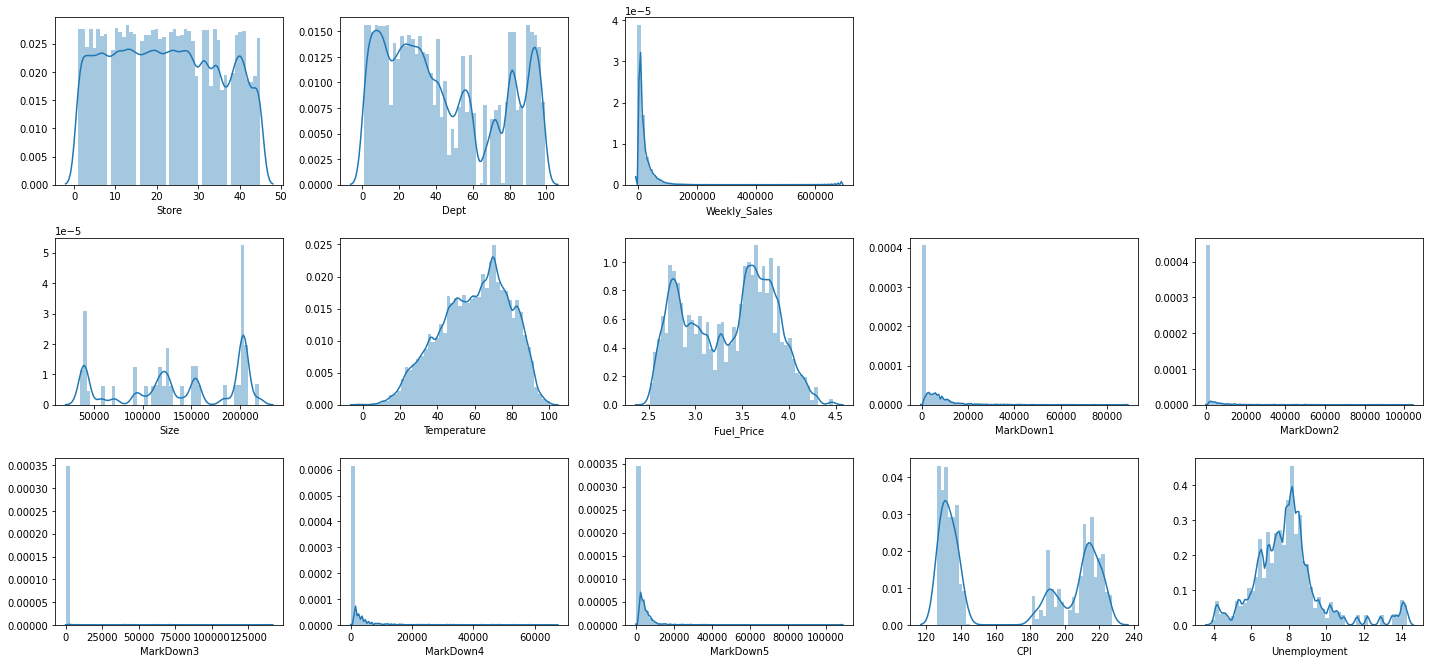

In [44]:
# Are there any outliers?
f = plt.figure(figsize=(20,15))
for count, col in enumerate(df):
    if df[col].dtype != object and df[col].dtype != bool:
        f.add_subplot(5,5, count+1)
        sns.distplot(df[col])
plt.tight_layout()
plt.show()

Looking at the distribution plots above, there are several features that don't have normal distributions. The most important one being the `Weekly_Sales`, which is very much right skewed. 

The `MarkDowns` also have a significant amount of outliers, but I am less worried about these, as they can help us understand the impact of discounts on sales. 

The rest of the features have a more normally distributed data. I will do some exploration on the `Weekly_Sales` to understand if the outliers are perhaps specific to ceirtain holidays or ceirtain stores.

In [47]:
df.Weekly_Sales.mean(), df.Weekly_Sales.std()  

(15981.25812346753, 22711.183519163056)

In [55]:
(df.Weekly_Sales > (df.Weekly_Sales.mean() + (df.Weekly_Sales.std()) * 2)).mean()

0.049607419882818984

We can see that a very small number of the data (~5%) is further than 3 standard deviations of the mean. We will leave these anomalies in the data, and we will try to better understand what insights they can give us.

# Explore

Now that the data is compiled into one dataframe, and it is in a tidy manner, with no missing values, we can move on to explore the data.

### Questions:

* Our first objective is to predict sales for each store for the next year. As such, we will focus on answering questions like:
    1. Is there a seasonality for `Weekly_Sales`
    1. Is there a trend for `Weekly_Sales`
    1. Is there a significant difference in sales between the different stores.
    1. How does trend and seasonality vary by department / type of store

* Our second question asks us to model the effects of `Markdowns` on holidays:
    1. Is there a relationship between `Markdowns` and holidays
    1. Is there a seasonality to `Markdowns`
    
* Our last objective is to make recommendations for the greater business:
    1. Are there any stores that are unprofitable?
    1. Are there time period where stores need to increase staffing due to seasonality?
    1. Does `fule_price` and `unemployment` have an impact on `Weekly_Sales`?
    
**There are many more questions that we could ask from this data - but these will be the ones that we will focus on at the moment. If there is more time to work on this analysis, we can look to extend our exploration phase.**

In [65]:
# Split our data

train = df[:"2011-12-31"]
validate = df["2012-01-01":"2012-06-01"]
test = df["2012-06-02":]

(array([733773., 733893., 734016., 734138., 734258., 734381., 734503.,
        734624., 734747., 734869.]),
 <a list of 10 Text major ticklabel objects>)

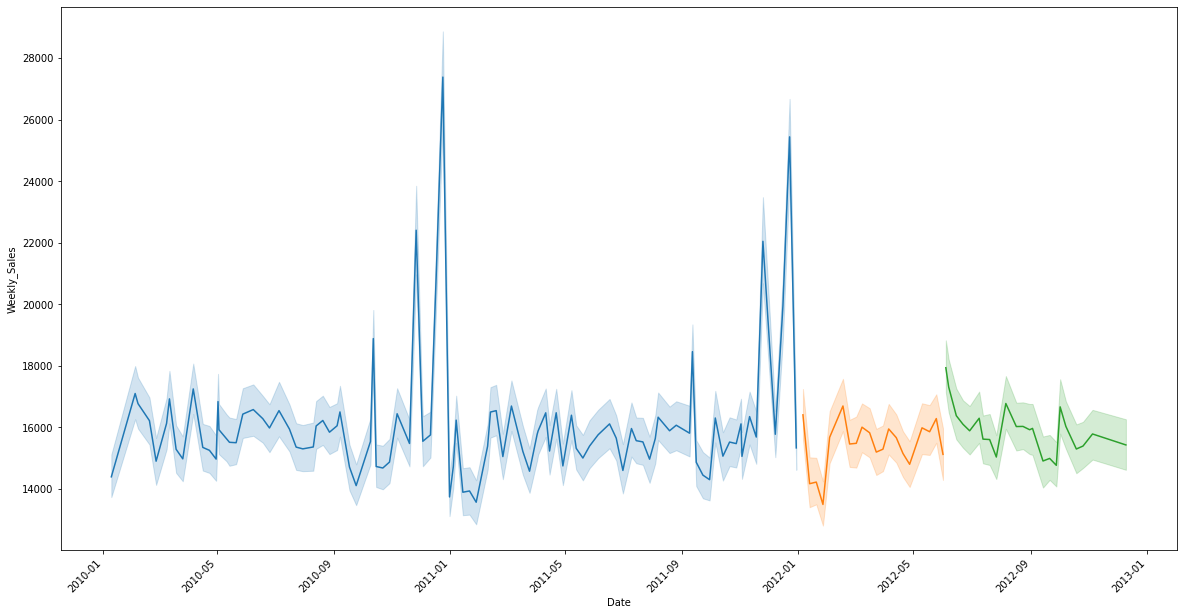

In [71]:
plt.figure(figsize=(20,10))
prepare.plot_splits(train, validate, test, "Weekly_Sales")
plt.xticks(rotation=45, ha="right")

### Is there a seasonality for Weekly_Sales?

In [73]:
import explore

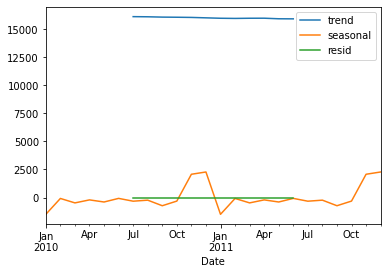

In [86]:
explore.seasonal_decomposition(train, "Weekly_Sales", "M")

Interestingly, it does seem that there is some seasonality in the data. Overall, it seems that sales pick up towards the beginning of November, all the way through Dec, and then sales drop towards early Jan.

This clearly reflects the holiday season, where people are likely buying presents for each other begining on Black Friday, through the Dec 25th. 

There actually seems to be a slighly negative trend in sales. This will need to be analysise further, as it can have a great impact on the business recommendations we make.

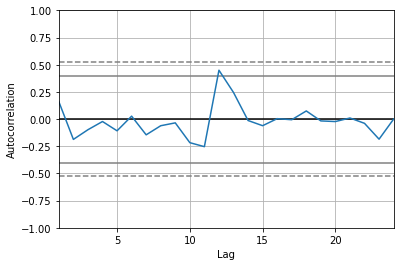

In [83]:
pd.plotting.autocorrelation_plot(train["Weekly_Sales"].resample("M").mean())

it doesn't actually seem like there is a significant correlation between sales and seasonality, as the lines in the autocorrelation graph are all within the error boudnaries. That is a bit suprising, and we might have to do some further analysis, as it might be that the outliers are actully skewing the data.

### Is there a trend for Weekly_Sales?

In [100]:
sales = train.Weekly_Sales.resample("M").mean()
sales

Date
2010-01-31    14391.780535
2010-02-28    16244.436211
2010-03-31    15828.833079
2010-04-30    15701.015586
2010-05-31    15971.989499
2010-06-30    16278.409330
2010-07-31    15785.689680
2010-08-31    15866.055025
2010-09-30    15339.655205
2010-10-31    15742.806495
2010-11-30    18118.582008
2010-12-31    18285.014095
2011-01-31    14471.611234
2011-02-28    15872.183056
2011-03-31    15490.811225
2011-04-30    15762.759190
2011-05-31    15524.557693
2011-06-30    15839.296649
2011-07-31    15324.714393
2011-08-31    15979.696402
2011-09-30    15587.117990
2011-10-31    15587.928852
2011-11-30    17069.858089
2011-12-31    19154.569311
Freq: M, Name: Weekly_Sales, dtype: float64

In [92]:
sales = train.Weekly_Sales.resample("M").mean()

sns.scatterplot(data=sales, x=sales.index, y=`Weekly_Sales")

AttributeError: 'DatetimeIndex' object has no attribute 'resample'